# MLGeometry guide

This introduction demonstrates how to use MLGeometry to:
1. Generate a hypersurface.
2. Build a bihomogeneous neural network.
3. Use the model to compute numerical Calabi-Yau metrics with the embedding method.
4. Plot $\eta$ on a rational curve.

## Install the package (on Colab)

In [ ]:
!pip install MLGeometry-JAX

## Configure imports

In [2]:
import numpy as np
import sympy as sp
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
import pickle

import MLGeometry as mlg
from MLGeometry import bihomoNN as bnn

Import the libraries to plot the $\eta$ on the rational curve (see the last section):

In [3]:
import os
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Set a random seed (optional)
Some random seed might be bad for numerical calulations. If there are any errors during the training, you may want to try a different seed.

In [4]:
np.random.seed(7)
rng = jax.random.PRNGKey(7)

## Define a hypersurface
First define a set of coordinates and a function as sympy symbols:

In [5]:
z0, z1, z2, z3, z4 = sp.symbols('z0, z1, z2, z3, z4')
Z = [z0,z1,z2,z3,z4]
f = z0**5 + z1**5 + z2**5 + z3**5 + z4**5 + 0.5*z0*z1*z2*z3*z4

Then define a hypersurface as a collection of points which solve the equation f = 0, using the `Hypersurface` class in the `mlg.hypersurface` module. The parameter n_pairs is the number of random pairs of points used to form the random lines in $\mathbf{CP}^{N+1}$. Then we take the intersections of those random lines and the hypersurface. By Bezout's theorem, each line intersects the hypersurface in precisely d points where d is the number of homogeneous coordinates. So the total number of points is d * n_pairs.

In [6]:
n_pairs = 10000
HS_train = mlg.hypersurface.Hypersurface(Z, f, n_pairs)
HS_test = mlg.hypersurface.Hypersurface(Z, f, n_pairs)

The Hypersurface class will take care of the patchwork automatically. Let's use the `list_patches` function to check the number of points on each patch:

In [7]:
HS_train.list_patches()

Number of Patches: 5
Points on patch 1 : 10171
Points on patch 2 : 10038
Points on patch 3 : 9783
Points on patch 4 : 10047
Points on patch 5 : 9961


You can also invoke this method on one of the patches to check the distribution on the subpatches:

In [8]:
HS_train.patches[0].list_patches()

Number of Patches: 4
Points on patch 1 : 2588
Points on patch 2 : 2530
Points on patch 3 : 2512
Points on patch 4 : 2541


The Hypersurface class contains some symbolic and numerical methods as well, which will be introduced elsewhere.

## Training with JAX

### Generate datasets
The `mlg.dataset.generate_dataset` function converts a hypersurface to a dataset dictionary, which has four componets: the points on the hypersurface, the volume form $\small \Omega \wedge \bar\Omega$, the mass reweighting the points distribution and the restriction which restricts the Kähler metric to a subpatch. The restriction contains an extra linear transformation so that points on different affine patches can all be processed in one call. It is also possible to generate a dataset only on one affine patch.

In [9]:
train_set = mlg.dataset.generate_dataset(HS_train)
test_set = mlg.dataset.generate_dataset(HS_test)

/Users/spencer/opt/miniconda3/envs/JAX/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:5638: ComplexWarning: Casting complex values to real discards the imaginary part
  out = np.asarray(object, dtype=dtype)


Shuffle and batch the datasets:

Let's look at what is inside a dataset:

In [10]:
for key, val in train_set.items():
    print(f"  {key}: shape {val.shape}, dtype {val.dtype}")

  points: shape (50000, 5), dtype complex64
  Omega_Omegabar: shape (50000,), dtype float32
  mass: shape (50000,), dtype float32
  restriction: shape (50000, 3, 5), dtype complex64


### Build a bihomogeneous neural network

The `mlg.bihomoNN` module provides the necessary layers (e.g. `Bihomogeneous` and `SquareDense` ) to construct the Kähler potential with a bihomogeneous neural network. Here is an example of a two-hidden-layer network (k = 4) with 70 and 100 hidden units:

In [11]:
class Kahler_potential(nn.Module):
    @nn.compact
    def __call__(self, inputs: jnp.ndarray) -> jnp.ndarray:
        x = bnn.Bihomogeneous(d=len(Z))(inputs)
        x = bnn.SquareDense(features=70)(x)
        x = bnn.SquareDense(features=100)(x)
        x = bnn.SquareDense(features=1, activation=None)(x)
        return jnp.log(x)

In [12]:
model = Kahler_potential()

### Train the model with Adam and L-BFGS
#### Adam
Setup the keras optmizer as `Adam` and the loss function as one of weighted loss in the `mlg.loss` module. Some available functions are `weighted_MAPE`, `weighted_MSE`, `max_error` and `MAPE_plus_max_error`. They are weighted with the mass formula since the points on the hypersurface are distributed according to the Fubini-Study measure while the measure used in the integration is determined by the volume form $\small \Omega \wedge \bar\Omega$.

Initialize the network:

In [23]:
loss_metric = mlg.loss.weighted_MAPE
BATCH_SIZE = 1000
optimizer = optax.adam(learning_rate=0.01)

Loop over the batches and train the network:

In [24]:
params, final_loss = mlg.trainer.train_optax(
    model=model,
    params=None, 
    dataset=train_set,
    optimizer=optimizer,
    epochs=100,
    batch_size=BATCH_SIZE,
    loss_metric=loss_metric,
    seed=7,
    verbose=True
)

Initializing parameters for input dimension 5...
Starting training with 100 epochs, 50 batches/epoch...
Epoch 1: Avg Loss = 0.19100
Epoch 10: Avg Loss = 0.01802
Epoch 20: Avg Loss = 0.01613
Epoch 30: Avg Loss = 0.01510
Epoch 40: Avg Loss = 0.01486
Epoch 50: Avg Loss = 0.01493
Epoch 60: Avg Loss = 0.01450
Epoch 70: Avg Loss = 0.01400
Epoch 80: Avg Loss = 0.01382
Epoch 90: Avg Loss = 0.01344
Epoch 100: Avg Loss = 0.01320
Training finished in 244.00s. Final Loss: 0.01320


Let's check the loss of the test dataset, with both MAPE and MSE:

In [25]:
sigma_test = mlg.loss.evaluate_dataset(model, params, test_set, mlg.loss.weighted_MAPE, BATCH_SIZE)
E_test = mlg.loss.evaluate_dataset(model, params, test_set, mlg.loss.weighted_MSE, BATCH_SIZE)
print("sigma_test = %.5f" % sigma_test)
print("E_test = %.5f" % E_test)

sigma_test = 0.01442
E_test = 0.00035


You can also check the error of the Monte Carlo integration, estimated by:

$$\delta \sigma = \frac{1}{\sqrt{N_p}} {\left( \int_X (|\eta - 1_X| - \sigma)^2 d\mu_{\Omega}\right)}^{1/2},$$

where $N_p$ is the number of points on the hypersurface and $\sigma$ is the `weighted_MAPE` loss, and

$$\eta = \frac{\det \omega}{\small \Omega \wedge \bar \Omega}$$

In [44]:
def delta_sigma_square_test(y_true, y_pred, mass):
    weights = mass / jnp.sum(mass)
    return jnp.sum((jnp.abs(y_true - y_pred) / y_true - sigma_test)**2 * weights)

delta_sigma_square = mlg.loss.evaluate_dataset(model, params, test_set, delta_sigma_square_test, BATCH_SIZE)
delta_sigma = math.sqrt(delta_sigma_square / len(test_set['points']))
print("delta_simga = %.7f" % delta_sigma)

delta_simga = 0.0000458


#### Save and Load
The parameters of the trained network can be saved by:

In [27]:
output_dir = 'trained_model'
os.makedirs(output_dir, exist_ok=True)
model_path = os.path.join(output_dir, '70_100_1.pkl')
    
with open(model_path, 'wb') as f_pkl:
    pickle.dump(params, f_pkl)

And loaded by:

In [28]:
with open(model_path, 'rb') as f_pkl:
    params = pickle.load(f_pkl)

#### L-BFGS
As elaborated in our paper, when the network getting more complicated, L-BFGS converges faster than Adam near the minima. It is recommanded to use it after pretraining with Adam. (Only ~50 iterations are shown here. In a real case you may want to set the `max_iter` to a larger value)

In [29]:
params, final_loss_lbfgs = mlg.trainer.train_lbfgs(
    model=model,
    params=params, 
    dataset=train_set,
    max_iter=20,
    loss_metric=loss_metric,
    batch_size=1000, # Enable gradient accumulation
    verbose=True
)

Starting L-BFGS training (Accumulated Gradients)...
Initial Loss: 0.01421
Iteration 1: Loss = 0.01347
Iteration 2: Loss = 0.01253
Iteration 3: Loss = 0.01129
Iteration 4: Loss = 0.01107
Iteration 5: Loss = 0.01095
Iteration 6: Loss = 0.01070
Iteration 7: Loss = 0.01061
Iteration 8: Loss = 0.01052
Iteration 9: Loss = 0.01046
Iteration 10: Loss = 0.01044
Iteration 11: Loss = 0.01042
Iteration 12: Loss = 0.01041
Iteration 13: Loss = 0.01040
Iteration 14: Loss = 0.01040
Iteration 15: Loss = 0.01040
Iteration 16: Loss = 0.01040
Iteration 17: Loss = 0.01039
Iteration 18: Loss = 0.01039
Iteration 19: Loss = 0.01038
Iteration 20: Loss = 0.01038
L-BFGS finished in 59.43s. Final Loss: 0.01038


You can also check the test dataset:

In [30]:
sigma_test = mlg.loss.evaluate_dataset(model, params, test_set, mlg.loss.weighted_MAPE, BATCH_SIZE)
E_test = mlg.loss.evaluate_dataset(model, params, test_set, mlg.loss.weighted_MSE, BATCH_SIZE)
print("sigma_test = %.5f" % sigma_test)
print("E_test = %.5f" % E_test)

sigma_test = 0.01052
E_test = 0.00022


#### Print out the metrics
One can check the explicit form of the trained metrics by:

In [31]:
cy_metric = mlg.loss.compute_cy_metric(model, params, test_set)
print(test_set['points'][5])
print(cy_metric[5])

[ 1.        -0.j          0.75895077-0.5679057j   0.59750503+0.46369216j
 -0.04038864+0.04861108j -0.29072744+0.27212238j]
[[ 2.084621  +2.9802322e-08j  0.03715153+1.5600305e-04j
   0.02226684-6.2180225e-02j]
 [ 0.03715155-1.5599397e-04j  0.9754703 +8.7311491e-10j
  -0.00676535+2.5440319e-03j]
 [ 0.02226683+6.2180318e-02j -0.00676535-2.5440333e-03j
   1.0665461 -3.7252903e-08j]]


### $\eta$ on the rational curve

Now let's retrict our model to a subspace and check the local behavior of $\eta$. With the quintic 3-fold f = 0, we can choose the embedding

$$(z_0, -z_0, z_1, 0, -z_1),$$

and the local coordinate system defined by $t = z_1 / z_0$. Using shperical coordinates $(\theta, \phi)$, it can be embedded into $\mathbb{R}^3$ by:

$$z_0 = \sin \theta \cos \phi, \qquad z_1= \sin \theta \sin \phi + i \cos \phi$$

So first sample the points on the rational curve:

In [32]:
theta, phi = np.linspace(0.001,np.pi+0.001, 400), np.linspace(0.001, 2*np.pi+0.001, 400)

points_list = []
for j in phi:
    for i in theta:
        t = complex(math.sin(i)*math.sin(j), math.cos(i)) / (math.sin(i)*math.cos(j))
        if np.absolute(t) <= 1:
            points_list.append([1, -1, t, 0, -t])
        else:
            # Use symmetry:
            points_list.append([1, -1, 1/t, 0, -1/t])

Use this set of points to generate the rational curve with norm_coordinate = z0 and max_grad_coordinate = z1:

In [33]:
rc = mlg.hypersurface.Hypersurface(Z, f, points=points_list, norm_coordinate=0, max_grad_coordinate=0)
rc_dataset = mlg.dataset.generate_dataset(rc)

/Users/spencer/opt/miniconda3/envs/JAX/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:5638: ComplexWarning: Casting complex values to real discards the imaginary part
  out = np.asarray(object, dtype=dtype)


Calculate $\eta$:

In [34]:
eta = mlg.loss.evaluate_dataset(model, params, rc_dataset, mlg.loss.eta_array, batch_size=1000)

Convert to Cartesian coordinates:

In [35]:
R = eta.reshape(400, 400)
THETA, PHI = np.meshgrid(theta, phi)
X = R * np.sin(THETA) * np.cos(PHI)
Y = R * np.sin(THETA) * np.sin(PHI)
ZZ = R * np.cos(THETA)

Plot the figure:

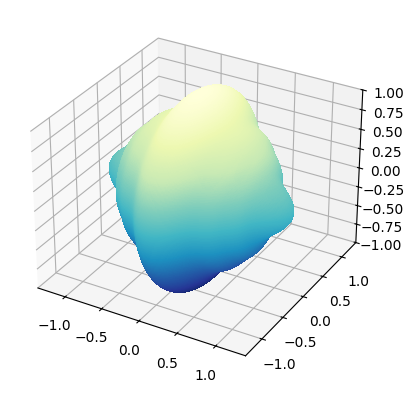

In [36]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.set_zlim3d(-1.0, 1.0)
plot = ax.plot_surface(
    X, Y, ZZ, rstride=1, cstride=1, cmap=plt.cm.YlGnBu_r,
    linewidth=0, antialiased=False)

$\eta$ is expected to approach constant function 1 as k increases.